In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA

# Data set

In [3]:
# Path
path_data = './data/'
path_uci = './data/UCI - 45/'

# Name of data set
name = 'mpg'

# Read csv
data = pd.read_csv(path_uci + name + '.csv')
data = data.dropna()

## Pre processing

In [4]:
# Variable selection
X = data.iloc[:, 1:-3]
y = data.iloc[:, 0]

# Split data set
rd = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rd)

# Principal Component Analysis
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

This part is where data for BIRT models are generated.

In [5]:
# Regression Models
models = [LinearRegression(), BayesianRidge(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf'),\
     KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
          AdaBoostRegressor(), MLPRegressor(), MLPRegressor(hidden_layer_sizes=(50, 50,))]

# Generate abilities/parameters for BIRT and other info.
irt = IRTModel(models= models)
irt.irtMatrix(X_train = X_train, y_train = y_train, X_test= X_test, y_test= y_test, normalize= True, base_models= True, name= name, rd= rd)

### Correlation Heatmap

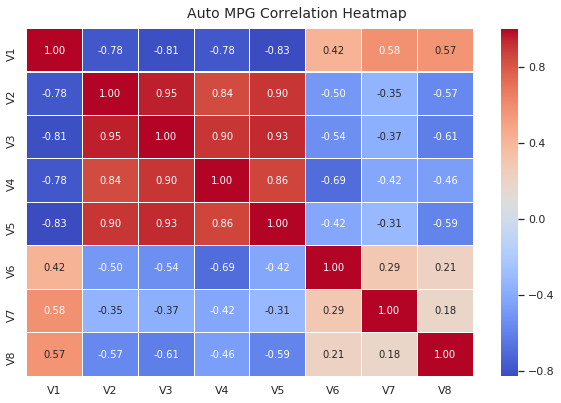

In [6]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Auto MPG Correlation Heatmap', fontsize=14)

# ICC

Item-Response Matrix:

In [7]:
path = './beta_irt/results/'
folder = 'mpg/'
name = 'mpg_s79_f20_sd42'

In [8]:
irt = pd.read_csv('./beta_irt/irt_data_' + name + '.csv')
X_pc1 = pd.read_csv('./beta_irt/xtest_' + name + '.csv').iloc[:,0].values.reshape(-1,1)
abilities = pd.read_csv(path + folder + 'irt_ability_vi_'+ name +'_am1@0_as1@0.csv')
ind = pd.read_csv('./info/testIndex_' + name + '.csv')
parameters = pd.read_csv(path + folder + 'irt_parameters_vi_'+ name +'_am1@0_as1@0.csv')
parameters.index = ind['index'].values
irt.index = ind['index'].values

In [9]:
irt.head()

,LinearRegression,BayesianRidge,SVR,SVR.1,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,AdaBoostRegressor,MLPRegressor,MLPRegressor.1,Optimal,Medium,Worst
79,0.378727,0.378436,0.422432,0.305271,0.536827,0.098355,0.136144,0.243909,0.051447,0.064107,0.999998,0.500049,0.000100
278,0.563234,0.562940,0.575582,0.442498,0.612801,0.818530,0.813608,0.623518,0.248486,0.380272,0.999936,0.500039,0.000107
250,0.192088,0.192182,0.205034,0.348152,0.226731,0.127860,0.168641,0.189537,0.316079,0.276829,0.999931,0.500085,0.000103
56,0.166204,0.166306,0.177089,0.396861,0.390223,0.446391,0.396947,0.181052,0.287273,0.443860,0.999997,0.500026,0.000109
393,0.737798,0.737462,0.707759,0.534875,0.935805,0.495120,0.744605,0.782118,0.655415,0.570851,0.999963,0.500035,0.000103


Search for instance:

In [10]:
instance = 257
irt.loc[irt.index == instance]

,LinearRegression,BayesianRidge,SVR,SVR.1,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,AdaBoostRegressor,MLPRegressor,MLPRegressor.1,Optimal,Medium,Worst
257,0.021475,0.021491,0.023851,0.060412,0.028358,0.015198,0.015997,0.020452,0.018908,0.017231,0.999926,0.500005,0.000105


In [11]:
difficulty = parameters.iloc[:,0].values
discrimination = parameters.iloc[:,1].values

In [12]:
ab = np.linspace(0.0001, 0.9999, 200)

## Plot parameters

In [13]:
concat = np.concatenate((X_pc1, y_test.values.reshape(-1,1)), axis = 1)

In [14]:
chosen_i = [143, 389, 257,85]

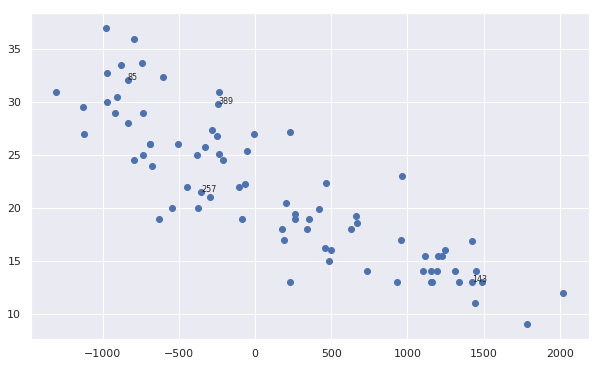

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(concat[:,0],concat[:,1])
for i, txt in enumerate(ind['index'].values):
    if txt in chosen_i:
        plt.text(concat[i,0],concat[i,1], str(txt), fontsize=8)
#     plt.text(concat[i,0],concat[i,1], str(txt), fontsize=8)

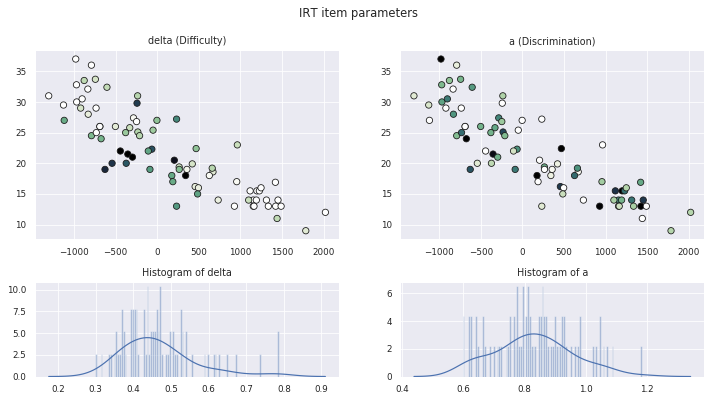

In [16]:
plot_parameters(concat, difficulty, discrimination).show()

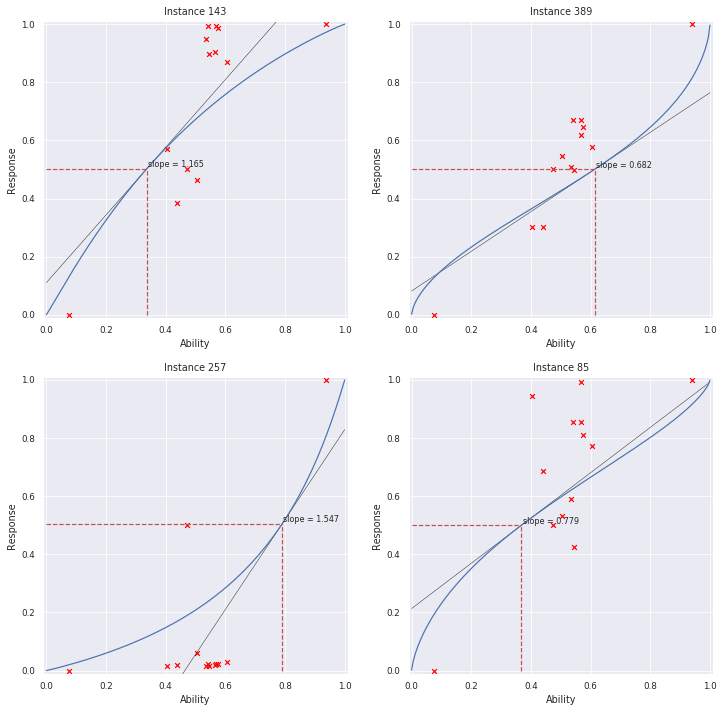

In [17]:
plt.figure(figsize=(12, 12))
for sub, i in enumerate(chosen_i):
    plt.subplot(2, 2, sub+1)
    par = parameters.loc[i,:].values
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=8)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities['ability'].values[:-1], irt.loc[irt.index == i].values[0], marker= 'x', c = 'red')
    plt.ylabel('Response')
    plt.xlabel('Ability')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Instance ' + str(i))

## MAE x Ability

In [18]:
mae = np.zeros(len(abilities)-1)
err_rel = np.absolute(y_test - y_test.mean())
for i, mod in enumerate(abilities.iloc[:-1, 0]):
    for j, rel in enumerate(err_rel):
        if mod == 'Worst':
            continue
        else:
            y = irt.iloc[j, i]
            mae[i] = mae[i] + ((1 - y)/y)*rel
mae = mae/len(y_test)
mae = np.delete(mae, -1)

In [19]:
mdls = ['  LR', 'Bayes', 'SVR - Linear', 'SVR - Rbf', 'KNR', 'DT', 'RF', 'AdaB', 'MLP (100)', 'MLP (50-50)', 'Optimal', 'Medium']
c_n = 'C0'
c_e = 'red'
color = [c_n, c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_e,c_e]

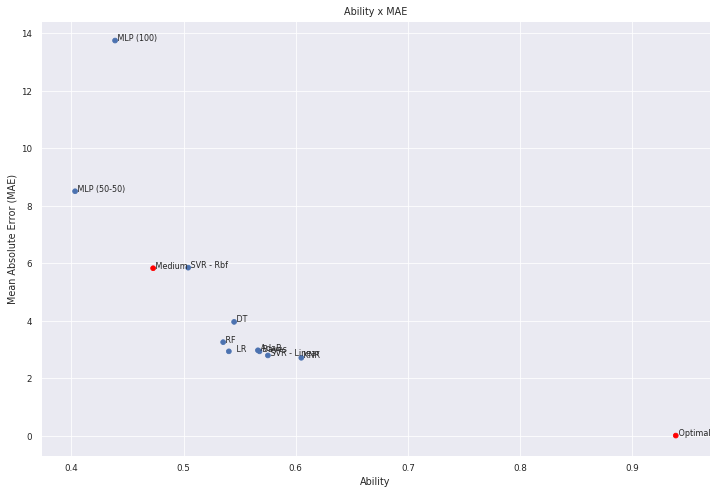

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(abilities.iloc[:-2, 1], mae, c= color)
for i, txt in enumerate(mdls):
    plt.text(abilities.iloc[i, 1], mae[i], ' '+txt, fontsize=8)
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Ability')
plt.title('Ability x MAE')
plt.show()